<a href="https://colab.research.google.com/github/wanifarooq/SwinIr/blob/main/SwinIr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This block ofcode is used to mount the **Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Weights & Biases** is the machine learning platform for developers to build better models faster. Use ***W&B's*** lightweight, interoperable tools to quickly track experiments, version and iterate on datasets, evaluate model performance, reproduce models, visualize results and spot regressions, and share findings with colleagues.

In [ ]:
!pip install wandb

**`timm`** is a deep-learning library created by ***Ross Wightman*** and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.

In [ ]:
!pip install timm

Importing different libraries

In [ ]:
import argparse
import sys
import random
import numpy as np
import wandb
import logging
import json
import re
import glob
import cv2
import os
import functools
import math
from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch
import torch.utils.checkpoint as checkpoint
from datetime import datetime
import torch.distributed as workDist
import torch.multiprocessing as mp
from collections import OrderedDict
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.optim import Adam
import torch.nn as nn
import warnings



1.   First line is being written to supress the **warnings**
2.   The second line of code is introduced to include different **image extension**.



In [ ]:
warnings.filterwarnings("ignore")
checkExtension = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tif']

**This blocks checks for the file type, whether it is image or not**

In [ ]:
def checkFileType(image):
    return any(image.endswith(extension) for extension in checkExtension)




1.   Returns the list of image paths from the directory(folder).
2.  The function argument is the path of the directory and the return is list of image paths.

In [ ]:
def getImagePaths(path):
    assert os.path.isdir(path), '{:s} is not valid directory so check it again'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if checkFileType(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} doesnot contain any valid images'.format(path)
    return images

Sorts the image paths, same for every dataset

In [ ]:
def imagePaths(dataroot):
    paths = None  
    if dataroot is not None:
        paths = sorted(getImagePaths(dataroot))
    return paths

Converts uint to float 

In [ ]:
def uint2single(img):
    return np.float32(img / 255.)

Loads the image from the image path as 


1.  **H*W*1**  for **grayscale**
2.  **H*W*2** **GGG** for **ndim =2**
3.  **H*W*3** **RGB** for **ndim =3**



In [ ]:
def imreadFromPath(path, n_channels=3):
    if n_channels == 1:
        img = cv2.imread(path, 0)  
        img = np.expand_dims(img, axis=2)  
    elif n_channels == 3:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

This function is used to **Augment** the images **to artificially expand the dataset** for different variations 

In [ ]:
def imageAugmentation(img, mode=0):
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(np.rot90(img))
    elif mode == 2:
        return np.flipud(img)
    elif mode == 3:
        return np.rot90(img, k=3)
    elif mode == 4:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 5:
        return np.rot90(img)
    elif mode == 6:
        return np.rot90(img, k=2)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

It shaves off the **extra pixels(remainder)** which exceed after the **scale** division

In [ ]:
def modCrop(img_in, scale):
    img = np.copy(img_in)
    if img.ndim == 2:
        H, W = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r]
    elif img.ndim == 3:
        H, W, C = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r, :]
    else:
        raise ValueError('the image dimensions are wrong: [{:d}].'.format(img.ndim))
    return img


Converts single numpy Tensor

In [ ]:
def single2tensor3(img):
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float()

To Load the dataset from the directory.

* It has inherited  **data.Dataset class** and uses the super function loaded with current class and the instance of the class.
* Stores the path of the both **L** and **H** images 
* Loads the images from the directory of the provided index 
* Does the random crop of the Low and high level images
* Augmentaion of images by many different variations
* **L/H** pairs, **HWC** to **CHW**, numpy to tensor
* Returns **L** , **H** and **L path **and **H path**





In [ ]:
class DatasetSR(data.Dataset):
    def __init__(self, jsonDetails):
        super(DatasetSR, self).__init__()
        self.jsonDetails = jsonDetails
        self.n_channels = jsonDetails['n_channels'] if jsonDetails['n_channels'] else 3
        self.sf = jsonDetails['scale'] if jsonDetails['scale'] else 4
        self.patch_size = self.jsonDetails['H_size'] if self.jsonDetails['H_size'] else 96
        self.L_size = self.patch_size // self.sf
        self.paths_H = imagePaths(jsonDetails['dataroot_H'])
        self.paths_L = imagePaths(jsonDetails['dataroot_L'])
        
        # To check for the number of the L paths is equal to the number of H paths
        assert self.paths_H, 'Does not contain any images'
        if self.paths_L and self.paths_H:
            assert len(self.paths_L) == len(self.paths_H), 'L/H mismatch - {}, {}.'.format(len(self.paths_L),len(self.paths_H))

    def __getitem__(self, index):

        L_path = None
        
        # gets the High resolution images
        H_path = self.paths_H[index]
        img_H = imreadFromPath(H_path, self.n_channels)

        # cropping the required part
        start = random.randrange(0, 360,4)
        end = start+120
        img_H = img_H[start:end,start:end]
        # img_H = img_H[60:420,60:420]
        
        img_H = uint2single(img_H)
        img_H = modCrop(img_H, self.sf)

        # get the Low resolution images
        if self.paths_L:
            L_path = self.paths_L[index]
            img_L = imreadFromPath(L_path, self.n_channels)
            start = int(start/4)
            end =start+30
            img_L = img_L[start:end,start:end]
            # img_L = img_L[15:105,15:105]
            img_L = uint2single(img_L)

        if self.jsonDetails['phase'] == 'train':
            H, W, C = img_L.shape

            # randomly crop the L patch
            rnd_h = random.randint(0, max(0, H - self.L_size))
            rnd_w = random.randint(0, max(0, W - self.L_size))
            img_L = img_L[rnd_h:rnd_h + self.L_size, rnd_w:rnd_w + self.L_size, :]

            # crop corresponding H patch
            rnd_h_H, rnd_w_H = int(rnd_h * self.sf), int(rnd_w * self.sf)
            img_H = img_H[rnd_h_H:rnd_h_H + self.patch_size, rnd_w_H:rnd_w_H + self.patch_size, :]

            # augmentation - flip and/or rotate
            mode = random.randint(0, 7)
            img_L, img_H = imageAugmentation(img_L, mode=mode), imageAugmentation(img_H, mode=mode)
        
        # L/H pairs, HWC to CHW, numpy to tensor
        img_H, img_L = single2tensor3(img_H), single2tensor3(img_L)
        if L_path is None:
            L_path = H_path

        return {'L': img_L, 'H': img_H, 'L_path': L_path, 'H_path': H_path}

    def __len__(self):
        return len(self.paths_H)




*  Setting up the **Log handler** , giving the log **handler name** and the **location** to store the log file

*   Checking if the handler already exist or create the new one 
*   overwriting the logger print to simultaneously **print and log** the logs





In [ ]:
def loggerSetup(logger_name, log_path='default_logger.log'):
    log = logging.getLogger(logger_name)
    if log.hasHandlers():
        print('Handler already exist!')
    else:
        print('Setting up the new handler!')
        level = logging.INFO
        formatter = logging.Formatter('%(asctime)s.%(msecs)03d : %(message)s', datefmt='%y-%m-%d %H:%M:%S')
        fh = logging.FileHandler(log_path, mode='a')
        fh.setFormatter(formatter)
        log.setLevel(level)
        log.addHandler(fh)
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        log.addHandler(sh)

class logger_print(object):
    def __init__(self, log_path="default.log"):
        self.terminal = sys.stdout
        self.log = open(log_path, 'a')
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)  
    def flush(self):
        pass




*   Checks whether paths is single or multiple (then iterates them) 
*   Makes **directory** for each of the path if it doesn't exist already



In [ ]:

def makeSingleDir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def makeTheDir(paths):
    if isinstance(paths, str):
        makeSingleDir(paths)
    else:
        for path in list(paths):
            makeSingleDir(path)


Loads The **configuration JSON** from directory given as opt_path


> Modifies the **dataset block** and checks for different parameters                 
> Creates the paths for different folders and adds them to configuration json      
> Network paramaters   
>  Default setting for **distributed dataparallel **   
>  Default setting for **optimizer**                              
> Default setting of **strict** for **model loading**        
>  **Exponential Moving Average** decay


In [ ]:
def loadTheJson(opt_path, is_train=True):
    json_str = ''
    with open(opt_path, 'r') as f:
        for line in f:
            line = line.split('//')[0] + '\n'
            json_str += line
    jsonDetails = json.loads(json_str, object_pairs_hook=OrderedDict)
    jsonDetails['opt_path'] = opt_path
    jsonDetails['is_train'] = is_train
    if 'scale' not in jsonDetails:
        jsonDetails['scale'] = 1

    # for dataset loader and checker
    for phase, dataset in jsonDetails['datasets'].items():
        phase = phase.split('_')[0]
        dataset['phase'] = phase
        dataset['scale'] = jsonDetails['scale']  # broadcast
        dataset['n_channels'] = jsonDetails['n_channels']  # broadcast
        if 'dataroot_H' in dataset and dataset['dataroot_H'] is not None:
            dataset['dataroot_H'] = os.path.expanduser(dataset['dataroot_H'])
        if 'dataroot_L' in dataset and dataset['dataroot_L'] is not None:
            dataset['dataroot_L'] = os.path.expanduser(dataset['dataroot_L'])

    # path checker and modifiers
    for key, path in jsonDetails['path'].items():
        if path and key in jsonDetails['path']:
            jsonDetails['path'][key] = os.path.expanduser(path)

    path_task = os.path.join(jsonDetails['path']['root'], jsonDetails['task'])
    jsonDetails['path']['task'] = path_task
    jsonDetails['path']['log'] = path_task
    jsonDetails['path']['options'] = os.path.join(path_task, 'options')

    if is_train:
        jsonDetails['path']['models'] = os.path.join(path_task, 'models')
        jsonDetails['path']['images'] = os.path.join(path_task, 'images')
    else:  
        jsonDetails['path']['images'] = os.path.join(path_task, 'test_images')

    
    # network
    jsonDetails['netG']['scale'] = jsonDetails['scale'] if 'scale' in jsonDetails else 1

    
    # GPU devices
    gpu_list = ','.join(str(x) for x in jsonDetails['gpu_ids'])
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
    print('export CUDA_VISIBLE_DEVICES=' + gpu_list)

    
    # default setting for distributeddataparallel
    if 'find_unused_parameters' not in jsonDetails:
        jsonDetails['find_unused_parameters'] = True
    if 'workDist' not in jsonDetails:
        jsonDetails['workDist'] = False
    jsonDetails['num_gpu'] = len(jsonDetails['gpu_ids'])
    print('number of GPUs is: ' + str(jsonDetails['num_gpu']))

    
    # default setting for optimizer
    if 'G_optimizer_reuse' not in jsonDetails['train']:
        jsonDetails['train']['G_optimizer_reuse'] = False
    if 'netD' in jsonDetails and 'D_optimizer_reuse' not in jsonDetails['train']:
        jsonDetails['train']['D_optimizer_reuse'] = False

    # default setting of strict for model loading
    if 'G_param_strict' not in jsonDetails['train']:
        jsonDetails['train']['G_param_strict'] = True
    if 'E_param_strict' not in jsonDetails['path']:
        jsonDetails['train']['E_param_strict'] = True

    # Exponential Moving Average
    if 'E_decay' not in jsonDetails['train']:
        jsonDetails['train']['E_decay'] = 0

    return jsonDetails




*   The **Multiprocessing** is intialized 
*  The **CUDA** runtime does not support the fork start method; either the spawn or forkserver start method are required to use CUDA in subprocesses.
* The server for multiprocessing is choosed
* It enables  to easily **parallelize** their computations across processes and clusters of machines
* The package is initialized using the **torch.distributed.init_process_group()** function before calling any other methods. This blocks until all processes have joined.
*Communication channel is given **GLOO** which support both **CPU** and **GPU** tensor communication, we can use **NCCL** for Gpu commuication only
* if distribution intilaization returns the **False**  it will **not allow** anyother API to get expose.
* **Rank** gives the number of current process and **world_size** gives number of processes participating in the job.



In [ ]:
def decTheLauncher(serverFrame, backend='gloo', **kwargs):
    if mp.get_start_method(allow_none=True) is None:
        mp.set_start_method('spawn')
    if serverFrame == 'pytorch':
        intializePytorch(backend, **kwargs)

    else:
        raise ValueError(f'Invalid serverFrame type: {serverFrame}')


def intializePytorch(backend, **kwargs):
    rank = int(os.environ['RANK'])
    num_gpus = torch.cuda.device_count()
    torch.cuda.set_device(rank % num_gpus)
    workDist.init_process_group(backend=backend, **kwargs)


def getDistributionInfo():
    if workDist.is_available():
        initialized = workDist.is_initialized()
    else:
        initialized = False
    if initialized:
        rank = workDist.get_rank()
        world_size = workDist.get_world_size()
    else:
        rank = 0
        world_size = 1
    return rank, world_size

* Load the **path** and **iteration** number of the last **checkpoint** for different net types or optimizers.
* If nothing is present in model folder then simply returns the **zeroth** iteration with **None** path


In [ ]:
def loadFromLastCheckpoint(save_dir, net_type='G'):
    file_list = glob.glob(os.path.join(save_dir, '*_{}.pth'.format(net_type)))
    if file_list:
        iter_exist = []
        for file_ in file_list:
            iter_current = re.findall(r"(\d+)_{}.pth".format(net_type), file_)
            iter_exist.append(int(iter_current[0]))
        init_iter = max(iter_exist)
        init_path = os.path.join(save_dir, '{}_{}.pth'.format(init_iter, net_type))
    else:
        init_iter = 0
        init_path = None
    return init_iter, init_path


Writing back the configured json in the models/option folder for using in future checking 🐜

In [ ]:
def currentTimeFormatted():
    return datetime.now().strftime('_%y%m%d_%H%M%S')


def save(jsonDetails):
    opt_path = jsonDetails['opt_path']
    opt_path_copy = jsonDetails['path']['options']
    dirname, filename_ext = os.path.split(opt_path)
    filename, ext = os.path.splitext(filename_ext)
    dump_path = os.path.join(opt_path_copy, filename + currentTimeFormatted() + ext)
    with open(dump_path, 'w') as dump_file:
        json.dump(jsonDetails, dump_file, indent=2)


* It Just creates the useful form of the **Dictionary** from the **configured json** and if the some key is called which is not present in the dictionary then rather throwing the exception **key not found** , we have **overloaded** the parent dict() class function of **missing**  to return **None** .
* Simply converts the **Dict** object to **Str** object for **messages** and **logs**

In [ ]:
def DictToNoneDict(jsonDetails):
    if isinstance(jsonDetails, dict):
        new_opt = dict()
        for key, sub_opt in jsonDetails.items():
            new_opt[key] = DictToNoneDict(sub_opt)
        return NoneDict(**new_opt)
    elif isinstance(jsonDetails, list):
        return [DictToNoneDict(sub_opt) for sub_opt in jsonDetails]
    else:
        return jsonDetails


class NoneDict(dict):
    def __missing__(self, key):
        return None


def dict2str(jsonDetails, indent_l=1):
    msg = ''
    for k, v in jsonDetails.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg



Call for DatasetSR with super resolution dataset configuration

In [ ]:
def loadDataPath(data_item):
    dataset_type = data_item['dataset_type'].lower()
    
    if dataset_type in ['sr', 'super-resolution']:
          
        return DatasetSR(data_item)
    else:
        raise NotImplementedError('no implemenation found for'.format(dataset_type))

**Making the Multi layer perceptron with two fully connected layers**
> Taking the number of inputs features equal to number of input channels here **180** 
> The hidden channels equal to mlp ratio times the input channels  **360**
> The output feature size here is equal to number of the input channels that is **180**
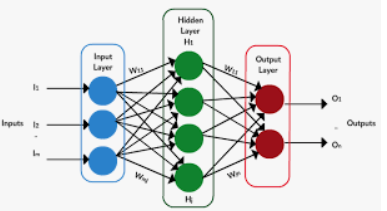

> Using the GELU activation layer and dropout custom percantage
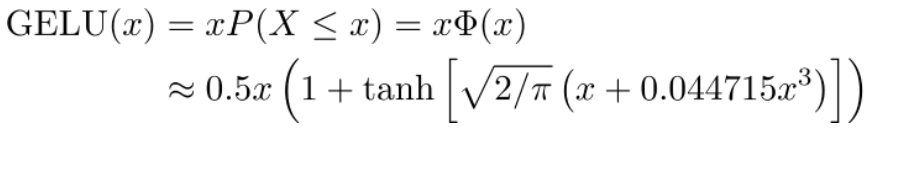

In [ ]:

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

The first function just partitions the image into the size of window


1.   the input argument is the (B,H,W,C) and window_size
2.   The return of the function is (number of windows ✖ B, window_size,Wondow_size,C)           

The role of second function is exactly the reverse of the first function.



In [ ]:
def windowPartition(x, window_size):
    
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def reverseWindow(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


##Window based multi-head self attention (W-MSA) module with relative position bias.It supports both of shifted and non-shifted window.


* ### It has number of input argument:


>1.  dim (int): Number of input channels.
>2.  window_size (tuple[int]): The height and width of the window.
>3. num_heads (int): Number of attention heads.
>4. qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
>5. qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
>6. attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
>7. proj_drop (float, optional): Dropout ratio of output. Default: 0.0



*   ### Define a parameter table of relative position bias
* ### It calculates the self attention on each window by just breaking it into key,query and value 
* ### The argument of the forward are:
>1. x: input features with shape of (num_windows*B, N, C)
>2. mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
* ### Calculate flops for 1 window with token length of N



In [ ]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  
        coords_flatten = torch.flatten(coords, 1) 
        relative_coords: object = coords_flatten[:, :, None] - coords_flatten[:, None, :] 
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

## Swin transformer
* ### The Arguments are:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm

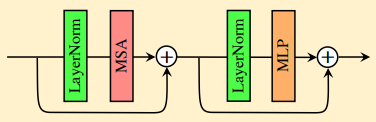

In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:

            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculateMask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculateMask(self, x_size):

        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1
        # nW, window_size, window_size, 1
        mask_windows = windowPartition(img_mask, self.window_size)  
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
       

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        # nW*B, window_size, window_size, C
        x_windows = windowPartition(shifted_x, self.window_size)
        # nW*B, window_size*window_size, C  
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  

        # W-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
             # nW*B, window_size*window_size, C
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  
        else:
            attn_windows = self.attn(x_windows, mask=self.calculateMask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = reverseWindow(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

##A basic Swin Transformer layer for one stage.
* The Input arguments are:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.

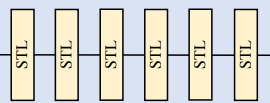

In [ ]:
class BasicLayer(nn.Module):
    

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

## Residual Swin Transformer Block (RSTB).
* The input Arguments are:
dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.

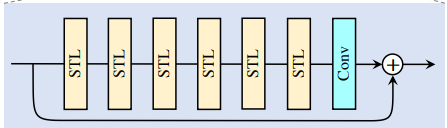

In [ ]:
class RSTB(nn.Module):
  

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops

## Image to Patch Embedding
* The input arguments are:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None

* The output of the forward will (B,number of pixels, channels)

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops



## Image to Patch Unembedding

* The Input Arguments are:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
  
* The output is (B,C,H,W)

In [ ]:
class PatchUnEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops

## The Upsample module.
This model upsamples or scale up the feature as much we need.
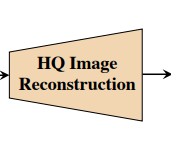

* Pixel shuffle Rearranges elements in a tensor of shape (B, C*r^2, H, W) 
 to a tensor of shape (B, C, H * r, W * r) where r is an upscale factor.


In [ ]:
class Upsample(nn.Sequential):
    
    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)



## SwinIR
* The Input Arguments are:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'

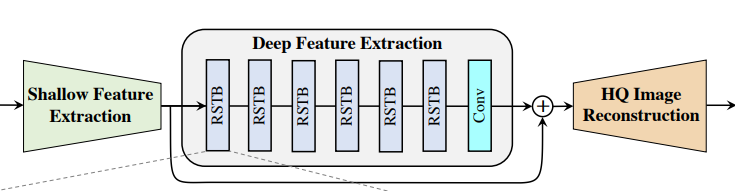

In [ ]:
class SwinIR(nn.Module):
  
    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler

        # 1, shallow feature extraction 
        self.conv_first_half = nn.Conv2d(num_in_ch, int(embed_dim/2), 3, 1, 1)
        self.conv_first = nn.Conv2d(int(embed_dim/2), embed_dim, 3, 1, 1)

        # 2, deep feature extraction 
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            raise NotImplementedError('no implemenation found for resi_connection of 3conv')

        # 3, high quality image reconstruction
        if self.upsampler == 'pixelshuffle':
            
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        else:
             raise NotImplementedError('no implemenation found for upscaler')

        self.apply(self.intializeWeights)

    def intializeWeights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def lowFreqFeatures(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            x = self.conv_first_half(x)
            x=  self.conv_first(x)
            x = self.conv_after_body(self.lowFreqFeatures(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        else:
            x_first = self.conv_first_half(x)
            x_first = self.conv_first(x_first)
            res = self.conv_after_body(self.lowFreqFeatures(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops


These are the regularization techniques taken from the official implementation

In [ ]:
def regualrizerOrth(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        w = m.weight.data.clone()
        c_out, c_in, f1, f2 = w.size()
        # dtype = m.weight.data.type()
        w = w.permute(2, 3, 1, 0).contiguous().view(f1 * f2 * c_in, c_out)
        # self.netG.apply(svd_orthogonalization)
        u, s, v = torch.svd(w)
        s[s > 1.5] = s[s > 1.5] - 1e-4
        s[s < 0.5] = s[s < 0.5] + 1e-4
        w = torch.mm(torch.mm(u, torch.diag(s)), v.t())
        m.weight.data = w.view(f1, f2, c_in, c_out).permute(3, 2, 0, 1)  # .type(dtype)
    else:
        pass


def regularizerClip(m):
    eps = 1e-4
    c_min = -1.5
    c_max = 1.5

    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        w = m.weight.data.clone()
        w[w > c_max] -= eps
        w[w < c_min] += eps
        m.weight.data = w

        if m.bias is not None:
            b = m.bias.data.clone()
            b[b > c_max] -= eps
            b[b < c_min] += eps
            m.bias.data = b


Base Model taken from official Implementation and anyother implementation is recommended to follow the same interface. 

In [ ]:
class ModelBase():
    def __init__(self, jsonDetails):
        self.jsonDetails = jsonDetails  # jsonDetails
        self.save_dir = jsonDetails['path']['models']  # save models
        self.device = torch.device('cuda' if jsonDetails['gpu_ids'] is not None else 'cpu')
        self.is_train = jsonDetails['is_train']  # training or not
        self.schedulers = []  # schedulers

    """
    # ----------------------------------------
    # Preparation before training with data
    # Save model during training
    # ----------------------------------------
    """

    def initTrain(self):
        pass

    def load(self):
        pass

    def save(self, label):
        pass

    def defineLoss(self):
        pass

    def defineOptimizer(self):
        pass

    def defineSchedular(self):
        pass

    """
    # ----------------------------------------
    # Optimization during training with data
    # Testing/evaluation
    # ----------------------------------------
    """

    def loadDataToModel(self, data):
        pass

    def ParamOptimization(self):
        pass

    def currentVisuals(self):
        pass

    def currentLosses(self):
        pass

    def getTheLearningRate(self, n):
        for scheduler in self.schedulers:
            scheduler.step(n)

    def CurrentLearningRate(self):
        return self.schedulers[0].get_lr()[0]

    def requires_grad(self, model, flag=True):
        for p in model.parameters():
            p.requires_grad = flag

    """
    # ----------------------------------------
    # Information of net
    # ----------------------------------------
    """

    def printNetwrok(self):
        pass

    def infoNetwork(self):
        pass

    def printParams(self):
        pass

    def infoParams(self):
        pass

    def getBareModel(self, network):
        """Get bare model, especially under wrapping with
        DistributedDataParallel or DataParallel.
        """
        if isinstance(network, (DataParallel, DistributedDataParallel)):
            network = network.module
        return network

    def model2device(self, network):
        """Model to device. It also warps models with DistributedDataParallel
        or DataParallel.
        Args:
            network (nn.Module)
        """
        network = network.to(self.device)
        if self.jsonDetails['workDist']:
            find_unused_parameters = self.jsonDetails['find_unused_parameters']
            network = DistributedDataParallel(network, device_ids=[torch.cuda.current_device()],
                                              find_unused_parameters=find_unused_parameters)
        else:
            network = DataParallel(network)
        return network

    # ----------------------------------------
    # network name and number of parameters
    # ----------------------------------------
    def explainNetworkChar(self, network):
        network = self.getBareModel(network)
        msg = '\n'
        msg += 'Networks name: {}'.format(network.__class__.__name__) + '\n'
        msg += 'Params number: {}'.format(sum(map(lambda x: x.numel(), network.parameters()))) + '\n'
        msg += 'Net structure:\n{}'.format(str(network)) + '\n'
        return msg

    # ----------------------------------------
    # parameters description
    # ----------------------------------------
    def explainParams(self, network):
        network = self.getBareModel(network)
        msg = '\n'
        msg += ' | {:^6s} | {:^6s} | {:^6s} | {:^6s} || {:<20s}'.format('mean', 'min', 'max', 'std', 'shape',
                                                                        'param_name') + '\n'
        for name, param in network.state_dict().items():
            if not 'num_batches_tracked' in name:
                v = param.data.clone().float()
                msg += ' | {:>6.3f} | {:>6.3f} | {:>6.3f} | {:>6.3f} | {} || {:s}'.format(v.mean(), v.min(), v.max(),
                                                                                          v.std(), v.shape, name) + '\n'
        return msg

    """
    # ----------------------------------------
    # Save prameters
    # Load prameters
    # ----------------------------------------
    """

    # ----------------------------------------
    # save the state_dict of the network
    # ----------------------------------------
    def saveNetwork(self, save_dir, network, network_label, iter_label):
        save_filename = '{}_{}.pth'.format(iter_label, network_label)
        save_path = os.path.join(save_dir, save_filename)
        network = self.getBareModel(network)
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    # ----------------------------------------
    # load the state_dict of the network
    # ----------------------------------------
    def loadNetwork(self, load_path, network, strict=True):
        network = self.getBareModel(network)
        if strict:
            network.load_state_dict(torch.load(load_path), strict=strict)
        else:
            state_dict_old = torch.load(load_path)
            state_dict = network.state_dict()
            for ((key_old, param_old), (key, param)) in zip(state_dict_old.items(), state_dict.items()):
                state_dict[key] = param_old
            network.load_state_dict(state_dict, strict=True)
            del state_dict_old, state_dict

    # ----------------------------------------
    # save the state_dict of the optimizer
    # ----------------------------------------
    def saveOptimzer(self, save_dir, optimizer, optimizer_label, iter_label):
        save_filename = '{}_{}.pth'.format(iter_label, optimizer_label)
        save_path = os.path.join(save_dir, save_filename)
        torch.save(optimizer.state_dict(), save_path)

    # ----------------------------------------
    # load the state_dict of the optimizer
    # ----------------------------------------
    def loadOptimizer(self, load_path, optimizer):
        optimizer.load_state_dict(
            torch.load(load_path, map_location=lambda storage, loc: storage.cuda(torch.cuda.current_device())))

    def updateEncod(self, decay=0.999):
        netG = self.getBareModel(self.netG)
        netG_params = dict(netG.named_parameters())
        netE_params = dict(self.netE.named_parameters())
        for k in netG_params.keys():
            netE_params[k].data.mul_(decay).add_(netG_params[k].data, alpha=1 - decay)

This block of the code is used to intialize the weights for the networks , If no argument is given network defination intialization is used 

In [ ]:
def initWeights(net, init_type='xavier_uniform', init_bn_type='uniform', gain=1):
    def customInit(m, init_type='xavier_uniform', init_bn_type='uniform', gain=1):
        raise "implementation error"

    if init_type not in ['default', 'none']:
        print('Initialization method [{:s} + {:s}], gain is [{:.2f}]'.format(init_type, init_bn_type, gain))
        fn = functools.partial(customInit, init_type=init_type, init_bn_type=init_bn_type, gain=gain)
        net.apply(fn)
    else:
        print('Pass this initialization! Initialization was done during network defination!')


Define the Network and then Intalize the weights

In [ ]:
# get the network
def defineNetworkArch(jsonDetails):
    opt_net = jsonDetails['netG']
    net_type = opt_net['net_type']
    if net_type == 'swinir':
        netG = SwinIR(upscale=opt_net['upscale'],
                      in_chans=opt_net['in_chans'],
                      img_size=opt_net['img_size'],
                      window_size=opt_net['window_size'],
                      img_range=opt_net['img_range'],
                      depths=opt_net['depths'],
                      embed_dim=opt_net['embed_dim'],
                      num_heads=opt_net['num_heads'],
                      mlp_ratio=opt_net['mlp_ratio'],
                      upsampler=opt_net['upsampler'],
                      resi_connection=opt_net['resi_connection'])

    else:
        raise NotImplementedError('netG [{:s}] is not found.'.format(net_type))

    
    # initialize weights
    if jsonDetails['is_train']:
        initWeights(netG,
                    init_type=opt_net['init_type'],
                    init_bn_type=opt_net['init_bn_type'],
                    gain=opt_net['init_gain'])

    return netG

The Generalized plain Model class for classical super resolution, which inherits the Model base class which can be implemented fro any type of resolution or noise removal by changing the implementation.
Here we are using only the absolute pixel loss as loss function for training.

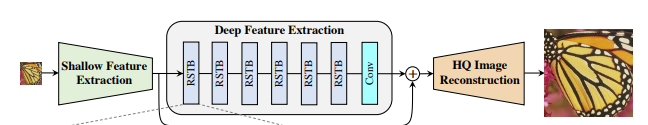

In [ ]:
class ModelPlain(ModelBase):
    def __init__(self, jsonDetails):
        super(ModelPlain, self).__init__(jsonDetails)
        
        
        #get the training Json
        self.opt_train = self.jsonDetails['train'] 

        # selective_network.py
        self.netG = defineNetworkArch(jsonDetails)

        # model to device (that is use the cuda)
        self.netG = self.model2device(self.netG)
        # Architecture for the encoder which we dont need here but is used for other reconstructions
        if self.opt_train['E_decay'] > 0:
            self.netE = defineNetworkArch(jsonDetails).to(self.device).eval()
        

    
    
    # initialize training
    def initTrain(self):
        # load model
        self.load()

        # set training mode,for BN  
        self.netG.train()
        # define loss  
        self.defineLoss()  
        # define optimizer
        self.defineOptimizer()
        # load optimizer  
        self.loadOptimzers() 
        # define scheduler 
        self.defineSchedular()
        #It is needed for logs  
        self.log_dict = OrderedDict()  

    
    # Load pre-trained G model
    def load(self):
        load_path_G = self.jsonDetails['path']['pretrained_netG']
        if load_path_G is not None:
            print('Loading model for G [{:s}] ...'.format(load_path_G))
            self.loadNetwork(load_path_G, self.netG, strict=self.opt_train['G_param_strict'])
        load_path_E = self.jsonDetails['path']['pretrained_netE']
        if self.opt_train['E_decay'] > 0:
            if load_path_E is not None:
                print('Loading model for E [{:s}] ...'.format(load_path_E))
                self.loadNetwork(load_path_E, self.netE, strict=self.opt_train['E_param_strict'])
            else:
                print('Copying model for E ...')
                self.updateEncod(0)
            self.netE.eval()

    #Load The optimizer
    def loadOptimzers(self):
        load_path_optimizerG = self.jsonDetails['path']['pretrained_optimizerG']
        if load_path_optimizerG is not None and self.opt_train['G_optimizer_reuse']:
            print('Loading optimizerG [{:s}] ...'.format(load_path_optimizerG))
            self.loadOptimizer(load_path_optimizerG, self.G_optimizer)

    # Save the Model and Optimizer 
    def save(self, iter_label):
        self.saveNetwork(self.save_dir, self.netG, 'G', iter_label)
        if self.opt_train['E_decay'] > 0:
            self.saveNetwork(self.save_dir, self.netE, 'E', iter_label)
        if self.opt_train['G_optimizer_reuse']:
            self.saveOptimzer(self.save_dir, self.G_optimizer, 'optimizerG', iter_label)

    def saveBetterModel(self, psnr, args, current_step):
        dir = args.model_save_dir
        model_name = str(self.opt_train['G_optimizer_lr']) + "_" + str(current_step) + "_" + str(psnr)
        self.saveNetwork(dir, self.netG, 'G', psnr)
        if self.opt_train['E_decay'] > 0:
            self.saveNetwork(dir, self.netE, 'E', psnr)
        if self.opt_train['G_optimizer_reuse']:
            self.saveOptimzer(dir, self.G_optimizer, 'optimizerG', psnr)

    # Define the loss function we are going to use
    def defineLoss(self):
        
        G_lossfn_type = self.opt_train['G_lossfn_type']
        if G_lossfn_type == 'l1':
            self.G_lossfn = nn.L1Loss().to(self.device)
        elif G_lossfn_type == 'l2':
            self.G_lossfn = nn.MSELoss().to(self.device)
        elif G_lossfn_type == 'l2sum':
            self.G_lossfn = nn.MSELoss(reduction='sum').to(self.device)

        else:
            raise NotImplementedError('Loss type [{:s}] is not found.'.format(G_lossfn_type))
        self.G_lossfn_weight = self.opt_train['G_lossfn_weight']  

    #Define the Optimizer default is Adam
    def defineOptimizer(self):
        G_optim_params = []
        for k, v in self.netG.named_parameters():
            if v.requires_grad:
                G_optim_params.append(v)
            else:
                print('Params [{:s}] will not optimize.'.format(k))
        self.G_optimizer = Adam(G_optim_params, lr=self.opt_train['G_optimizer_lr'], weight_decay=0)

    #Define the Schedular to use the multi step learning
    def defineSchedular(self):
       self.schedulers.append(lr_scheduler.MultiStepLR(self.G_optimizer,
                                                        self.opt_train['G_scheduler_milestones'],
                                                        self.opt_train['G_scheduler_gamma'], verbose=False
                                                        ))

    
    # Feed the data from the  L/H dictionary
    def loadDataToModel(self, data, need_H=True):
        self.L = data['L'].to(self.device)
        if need_H:
            self.H = data['H'].to(self.device)

    #Give the forward pass
    def netForwardPass(self):
        self.E = self.netG(self.L)

    #give the forward pass
    ##Get the loss 
    ### Do Backpropagation and Update the parameters
    def ParamOptimization(self, current_step):
        self.G_optimizer.zero_grad()
        self.netForwardPass()
        G_loss = self.G_lossfn_weight * self.G_lossfn(self.E, self.H)
        G_loss.backward()
        
        # Regularizations

        # `clip_grad_norm` helps prevent the exploding gradient problem.
        G_optimizer_clipgrad = self.opt_train['G_optimizer_clipgrad'] if self.opt_train['G_optimizer_clipgrad'] else 0
        if G_optimizer_clipgrad > 0:
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=self.opt_train['G_optimizer_clipgrad'],
                                           norm_type=2)

        self.G_optimizer.step()

        
        # regularizer
        G_regularizer_orthstep = self.opt_train['G_regularizer_orthstep'] if self.opt_train[
            'G_regularizer_orthstep'] else 0
        if G_regularizer_orthstep > 0 and current_step % G_regularizer_orthstep == 0 and current_step % \
                self.jsonDetails['train']['checkpoint_save'] != 0:
            self.netG.apply(regualrizerOrth)
        G_regularizer_clipstep = self.opt_train['G_regularizer_clipstep'] if self.opt_train[
            'G_regularizer_clipstep'] else 0
        if G_regularizer_clipstep > 0 and current_step % G_regularizer_clipstep == 0 and current_step % \
                self.jsonDetails['train']['checkpoint_save'] != 0:
            self.netG.apply(regularizerClip)

        
        # Store the loss in log dictionary
        self.log_dict['G_loss'] = G_loss.item()
        
        #update the E network
        if self.opt_train['E_decay'] > 0:
            self.updateEncod(self.opt_train['E_decay'])

    #test to new images
    def test(self):
        self.netG.eval()
        with torch.no_grad():
            self.netForwardPass()
        self.netG.train()

    # Get the log dictionary
    def getCurrentLog(self):
        return self.log_dict

    # Visualize the from G,E and H by detaching from tensor
    def currentVisuals(self, need_H=True):
        out_dict = OrderedDict()
        out_dict['L'] = self.L.detach()[0].float().cpu()
        out_dict['E'] = self.E.detach()[0].float().cpu()
        if need_H:
            out_dict['H'] = self.H.detach()[0].float().cpu()
        return out_dict

    
    # get L, E, H batch images
    def current_results(self, need_H=True):
        out_dict = OrderedDict()
        out_dict['L'] = self.L.detach().float().cpu()
        out_dict['E'] = self.E.detach().float().cpu()
        if need_H:
            out_dict['H'] = self.H.detach().float().cpu()
        return out_dict

    
    # print network
    def printNetwrok(self):
        msg = self.explainNetworkChar(self.netG)
        print(msg)

   
    # print params
    def printParams(self):
        msg = self.explainParams(self.netG)
        print(msg)

    
    # network information
    def infoNetwork(self):
        msg = self.explainNetworkChar(self.netG)
        return msg

    
    # params information
    def infoParams(self):
        msg = self.explainParams(self.netG)
        return msg


In [ ]:
def makeModel(jsonDetails):
    model = jsonDetails['model']

    if model == 'plain':
         
        return ModelPlain(jsonDetails)
    else:
        raise NotImplementedError('Model [{:s}] is not defined.'.format(model))

# This section of the code is now for the automatic evaluation of the Set5.
## This is taken directly from the official implementation with minor modifications

In [ ]:
def convertInputRange(img):
    """Convert the type and range of the input image.
    It converts the input image to np.float32 type and range of [0, 1].
    It is mainly used for pre-processing the input image in colorspace
    convertion functions such as rgb2ycbcr and ycbcr2rgb.
    Args:
        img (ndarray): The input image. It accepts:
            1. np.uint8 type with range [0, 255];
            2. np.float32 type with range [0, 1].
    Returns:
        (ndarray): The converted image with type of np.float32 and range of
            [0, 1].
    """
    img_type = img.dtype
    img = img.astype(np.float32)
    if img_type == np.float32:
        pass
    elif img_type == np.uint8:
        img /= 255.
    else:
        raise TypeError('The img type should be np.float32 or np.uint8, ' f'but got {img_type}')
    return img


In [ ]:
def convertOuputRange(img, dst_type):
    """Convert the type and range of the image according to dst_type.
    It converts the image to desired type and range. If `dst_type` is np.uint8,
    images will be converted to np.uint8 type with range [0, 255]. If
    `dst_type` is np.float32, it converts the image to np.float32 type with
    range [0, 1].
    It is mainly used for post-processing images in colorspace convertion
    functions such as rgb2ycbcr and ycbcr2rgb.
    Args:
        img (ndarray): The image to be converted with np.float32 type and
            range [0, 255].
        dst_type (np.uint8 | np.float32): If dst_type is np.uint8, it
            converts the image to np.uint8 type with range [0, 255]. If
            dst_type is np.float32, it converts the image to np.float32 type
            with range [0, 1].
    Returns:
        (ndarray): The converted image with desired type and range.
    """
    if dst_type not in (np.uint8, np.float32):
        raise TypeError('The dst_type should be np.float32 or np.uint8, ' f'but got {dst_type}')
    if dst_type == np.uint8:
        img = img.round()
    else:
        img /= 255.
    return img.astype(dst_type)



In [ ]:
def changeChannelOrder(img, input_order='HWC'):
    """Reorder images to 'HWC' order.
    If the input_order is (h, w), return (h, w, 1);
    If the input_order is (c, h, w), return (h, w, c);
    If the input_order is (h, w, c), return as it is.
    Args:
        img (ndarray): Input image.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            If the input image shape is (h, w), input_order will not have
            effects. Default: 'HWC'.
    Returns:
        ndarray: reordered image.
    """

    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' "'HWC' and 'CHW'")
    if len(img.shape) == 2:
        img = img[..., None]
    if input_order == 'CHW':
        img = img.transpose(1, 2, 0)
    return img



In [ ]:
def toYchannel(img):
    """Change to Y channel of YCbCr.
    Args:
        img (ndarray): Images with range [0, 255].
    Returns:
        (ndarray): Images with range [0, 255] (float type) without round.
    """
    img = img.astype(np.float32) / 255.
    if img.ndim == 3 and img.shape[2] == 3:
        img = bgr2ycbcr(img, y_only=True)
        img = img[..., None]
    return img * 255.


In [ ]:
def bgr2ycbcr(img, y_only=False):
    """Convert a BGR image to YCbCr image.
    The bgr version of rgb2ycbcr.
    It implements the ITU-R BT.601 conversion for standard-definition
    television. See more details in
    https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion.
    It differs from a similar function in cv2.cvtColor: `BGR <-> YCrCb`.
    In OpenCV, it implements a JPEG conversion. See more details in
    https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion.
    Args:
        img (ndarray): The input image. It accepts:
            1. np.uint8 type with range [0, 255];
            2. np.float32 type with range [0, 1].
        y_only (bool): Whether to only return Y channel. Default: False.
    Returns:
        ndarray: The converted YCbCr image. The output image has the same type
            and range as input image.
    """
    img_type = img.dtype
    img = convertInputRange(img)
    if y_only:
        out_img = np.dot(img, [24.966, 128.553, 65.481]) + 16.0
    else:
        out_img = np.matmul(
            img, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [16, 128, 128]
    out_img = convertOuputRange(out_img, img_type)
    return out_img

In [ ]:
# ---------------for SwinIR set5 validation------------------------
def calPsnrofImage(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate PSNR (Peak Signal-to-Noise Ratio).
    Ref: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the PSNR calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.
    Returns:
        float: psnr result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = changeChannelOrder(img1, input_order=input_order)
    img2 = changeChannelOrder(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = toYchannel(img1)
        img2 = toYchannel(img2)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20. * np.log10(255. / np.sqrt(mse))

In [ ]:

def calSSIMOfImage(img1, img2):
    """Calculate SSIM (structural similarity) for one channel images.
    It is called by func:`calculate_ssim`.
    Args:
        img1 (ndarray): Images with range [0, 255] with order 'HWC'.
        img2 (ndarray): Images with range [0, 255] with order 'HWC'.
    Returns:
        float: ssim result.
    """

    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()



SSIM is used as a metric to measure the similarity between two given images. 
The Structural Similarity Index (SSIM) metric extracts 3 key features from an image:  
   * Luminance 
   * Contrast
   * Structure   
**Luminance:** Luminance is measured by averaging over all the pixel values. Its denoted by μ (Mu) and the formula is given below.  
**Contrast:** It is measured by taking the standard deviation (square root of variance) of all the pixel values. It is denoted by σ (sigma) and represented by the formula below.  
**Structure:** The structural comparison is done by using a consolidated formula (more on that later) but in essence, we divide the input signal with its standard deviation so that the result has unit standard deviation which allows for a more robust comparison.  
And finally, the SSIM score is given by,  
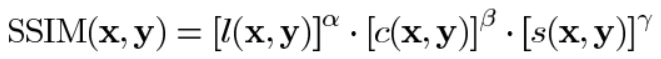  


where α > 0, β > 0, γ > 0 denote the relative importance of each of the metrics. To simplify the expression, if we assume, α = β = γ = 1 and C3 = C2/2, we can get,  

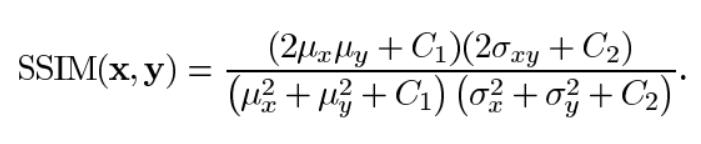


In [ ]:
def returnSSIMofImage(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate SSIM (structural similarity).
    Ref:
    Image quality assessment: From error visibility to structural similarity
    The results are the same as that of the official released MATLAB code in
    https://ece.uwaterloo.ca/~z70wang/research/ssim/.
    For three-channel images, SSIM is calculated for each channel and then
    averaged.
    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the SSIM calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.
    Returns:
        float: ssim result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = changeChannelOrder(img1, input_order=input_order)
    img2 = changeChannelOrder(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = toYchannel(img1)
        img2 = toYchannel(img2)

    ssims = []
    for i in range(img1.shape[2]):
        ssims.append(calSSIMOfImage(img1[..., i], img2[..., i]))
    return np.array(ssims).mean()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def setup(args):
    save_dir = f'/content/drive/MyDrive/SwinIr/set5test_results/swinir_{args.task}_x{args.scale}'
    folder = args.folder_gt
    border = args.scale
    window_size = 6
    return folder, save_dir, border, window_size

In [ ]:
def getValImagePair(args, path):
    (imgname, imgext) = os.path.splitext(os.path.basename(path))
    img_gt = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32) / 255.
    img_lq = cv2.imread(f'{args.folder_lq}/{imgname}x{args.scale}{imgext}', cv2.IMREAD_COLOR).astype(
        np.float32) / 255.
    return imgname, img_lq, img_gt


This function calculates the absolute Peak signal to noise ratio .  
Taking the root mean square of the pixel differences between the two images. 
The mathematical representation of the PSNR is as follows:
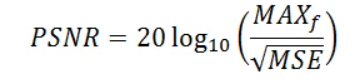  
Where the mean square error is: 
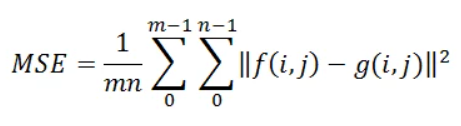  
The proposal is that the higher the PSNR, the better degraded image has been reconstructed to match the original image and the better the reconstructive algorithm.  This would occur because we wish to minimize the MSE between images with respect the maximum signal value of the image.



In [ ]:
def validateSet(args, model):
    # setup folder and path
    folder, save_dir, border, window_size = setup(args)
    os.makedirs(save_dir, exist_ok=True)
    test_results = OrderedDict()
    test_results['psnr'] = []
    test_results['ssim'] = []
    test_results['psnr_y'] = []
    test_results['ssim_y'] = []

    psnr, ssim, psnr_y, ssim_y = 0, 0, 0, 0
    for idx, path in enumerate(sorted(glob.glob(os.path.join(folder, '*')))):
        # read image
        imgname, img_lq, img_gt = getValImagePair(args, path)  # image to HWC-BGR, float32
        img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]],
                              (2, 0, 1))  # HCW-BGR to CHW-RGB
        img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device)  # CHW-RGB to NCHW-RGB

        # inference
        with torch.no_grad():
            # pad input image to be a multiple of window_size
            _, _, h_old, w_old = img_lq.size()
            h_pad = (h_old // window_size + 1) * window_size - h_old
            w_pad = (w_old // window_size + 1) * window_size - w_old
            img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
            img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]

            test_data = {'L': img_lq, 'H': img_gt}
            model.loadDataToModel(test_data, need_H=False)
            model.test()
            output = model.E
            output = output[..., :h_old * args.scale, :w_old * args.scale]

        # save image
        output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        if output.ndim == 3:
            output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # CHW-RGB to HCW-BGR
        output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
        cv2.imwrite(f'{save_dir}/{imgname}_SwinIR.png', output)
        # set5 validation image

        # evaluate psnr/ssim/psnr_b
        if img_gt is not None:
            img_gt = (img_gt * 255.0).round().astype(np.uint8)  # float32 to uint8
            img_gt = img_gt[:h_old * args.scale, :w_old * args.scale, ...]  # crop gt
            img_gt = np.squeeze(img_gt)

            psnr = calPsnrofImage(output, img_gt, crop_border=border)
            ssim = returnSSIMofImage(output, img_gt, crop_border=border)
            test_results['psnr'].append(psnr)
            test_results['ssim'].append(ssim)
            if img_gt.ndim == 3:  # RGB image
                psnr_y = calPsnrofImage(output, img_gt, crop_border=border, test_y_channel=True)
                ssim_y = returnSSIMofImage(output, img_gt, crop_border=border, test_y_channel=True)
                test_results['psnr_y'].append(psnr_y)
                test_results['ssim_y'].append(ssim_y)

            print('Testing {:d} {:20s} - PSNR: {:.2f} dB; SSIM: {:.4f}; '
                  'PSNR_Y: {:.2f} dB; SSIM_Y: {:.4f};'.
                  format(idx, imgname, psnr, ssim, psnr_y, ssim_y))
        else:
            print('Testing {:d} {:20s}'.format(idx, imgname))

    # summarize psnr/ssim
    if img_gt is not None:
        ave_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
        ave_ssim = sum(test_results['ssim']) / len(test_results['ssim'])
        print(
            '\n{} \n-- Average PSNR/SSIM(RGB): {:.2f} dB; {:.4f}'.format(save_dir, ave_psnr, ave_ssim))
        if img_gt.ndim == 3:
            ave_psnr_y = sum(test_results['psnr_y']) / len(test_results['psnr_y'])
            ave_ssim_y = sum(test_results['ssim_y']) / len(test_results['ssim_y'])
            print('-- Average PSNR_Y/SSIM_Y: {:.2f} dB; {:.4f}'.format(ave_psnr_y, ave_ssim_y))

    return ave_psnr_y

In [ ]:
def main(args):
    jsonDetails = loadTheJson(configLoader.parse_args().jsonDetails, is_train=True)
    jsonDetails['workDist'] = configLoader.parse_args().workDist
    if jsonDetails['workDist']:
        decTheLauncher('pytorch')
    jsonDetails['rank'], jsonDetails['world_size'] = getDistributionInfo()
    if jsonDetails['rank'] == 0:
        makeTheDir((path for key, path in jsonDetails['path'].items() if 'pretrained' not in key))
    if jsonDetails['rank'] == 0:
        wandb.login(key="4532554eb8a1bfe57ebff8dfb0b498c7086e461f")
        wandb.init(project="SwinIR")

    iterG, pathG = loadFromLastCheckpoint(jsonDetails['path']['models'], net_type='G')
    iterE, pathE = loadFromLastCheckpoint(jsonDetails['path']['models'], net_type='E')
    jsonDetails['path']['pretrained_netG'] = pathG
    jsonDetails['path']['pretrained_netE'] = pathE

    iterOptG, pathOptG = loadFromLastCheckpoint(jsonDetails['path']['models'],
                                                net_type='optimizerG')
    jsonDetails['path']['pretrained_optimizerG'] = pathOptG
    current_step = max(iterG, iterE, iterOptG)

    # Save the Json
    if jsonDetails['rank'] == 0:
        save(jsonDetails)

    jsonDetails = DictToNoneDict(jsonDetails)
    if jsonDetails['rank'] == 0:
        logger_name = 'train'
        loggerSetup(logger_name, os.path.join(jsonDetails['path']['log'], logger_name + '.log'))
        logger = logging.getLogger(logger_name)
        logger.info(dict2str(jsonDetails))
    seed = jsonDetails['train']['manual_seed']
    if seed is None:
        seed = random.randint(1, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    for phase, data_item in jsonDetails['datasets'].items():
        if phase == 'train':
            train_path = loadDataPath(data_item)
            train_size = int(math.ceil(len(train_path) / data_item['dataloader_batch_size']))
            if jsonDetails['rank'] == 0:
                logger.info('Number of train images: {:,d}, iters: {:,d}'.format(len(train_path), train_size))
            if jsonDetails['workDist']:
                train_sampler = DistributedSampler(train_path, shuffle=data_item['dataloader_shuffle'], drop_last=True,
                                                   seed=seed)

                train_loader = DataLoader(train_path,
                                          batch_size=data_item['dataloader_batch_size'] // jsonDetails['num_gpu'],
                                          shuffle=False,
                                          num_workers=data_item['dataloader_num_workers'] // jsonDetails['num_gpu'],
                                          drop_last=True,
                                          pin_memory=True,
                                          sampler=train_sampler)

            else:
                train_loader = DataLoader(train_path,
                                          batch_size=data_item['dataloader_batch_size'],
                                          shuffle=data_item['dataloader_shuffle'],
                                          num_workers=data_item['dataloader_num_workers'],
                                          drop_last=True,
                                          pin_memory=True)

        
        elif phase == 'test':
            test_path = loadDataPath(data_item)
            test_loader = DataLoader(test_path, batch_size=1,
                                     shuffle=False, num_workers=1,
                                     drop_last=False, pin_memory=True)


        else:
            raise NotImplementedError("Phase [%s] is not recognized." % phase)

    # define the model for training and testing
    model = makeModel(jsonDetails)
    model.initTrain()

    psnr_y_record = 0

    for epoch in range(50):  
        L1_loss = 0
        # print(len(train_loader))
        for i, train_data in enumerate(train_loader):

            current_step += 1

            # update the learning rate
            model.getTheLearningRate(current_step)

            # Feed the pairs of Data
            model.loadDataToModel(train_data)

            # optimize the Parameters
            model.ParamOptimization(current_step)

            # Training information
            logs = model.getCurrentLog()  

            if current_step % jsonDetails['train']['checkpoint_print'] == 0 and jsonDetails['rank'] == 0:
                message = '<epoch:{:3d}, iter:{:8,d}, lr:{:.3e}> '.format(epoch, current_step,model.CurrentLearningRate())
                for k, v in logs.items():  
                    message += '{:s}: {:.3e} '.format(k, v)
                logger.info(message)
                wandb.log({"train_l1_loss": logs['G_loss']})

            # Testing
            if current_step % jsonDetails['train']['checkpoint_test'] == 0 and jsonDetails['rank'] == 0:
                print(" ----set5 validation---")
                print("current_step: ", current_step)
                psnr_y = validateSet(args, model)

                wandb.log({"val_loss": psnr_y})

                if (psnr_y > psnr_y_record):
                    model.saveBetterModel(psnr_y, args, current_step)
                psnr_y_record = psnr_y
                message = "---validation at " + str(current_step) + " iter, PSNR = " + str(psnr_y_record) + "---"
                logger.info(message)

            # save the model
            if current_step % jsonDetails['train']['checkpoint_save'] == 0 and jsonDetails['rank'] == 0:
                logger.info('Saving the model.')
                print("saving model")
                model.save(current_step)

            if jsonDetails['rank'] == 0:
                L1_loss += logs['G_loss']
                print(current_step,i, len(train_loader), 'l1Loss: %.3f' % (L1_loss / (i + 1)))

In [ ]:

if __name__ == '__main__':
    # CONFIG_FILE = 'config.config_ipynb'
    # if os.path.isfile(CONFIG_FILE):
    #     with open(CONFIG_FILE) as f:
    #         sys.argv = f.read().split()

    configLoader = argparse.ArgumentParser()
    configLoader.add_argument('-f')
    configLoader.add_argument('--jsonDetails', type=str, default="/content/drive/MyDrive/SwinIr/classical_sr.json")
    configLoader.add_argument('--serverFrame', default='pytorch')
    configLoader.add_argument('--local_rank', type=int, default=0)
    configLoader.add_argument('--workDist', default=False)
    
    # Calling for the set5 Validation
    configLoader.add_argument('--task', type=str, default='classical_sr')
    configLoader.add_argument('--scale', type=int, default=4)
    
    # Give the path of test set 
    configLoader.add_argument('--folder_lq', type=str, default="/content/drive/MyDrive/SwinIr/testsets/set5/LR_bicubic/X4/")
    configLoader.add_argument('--folder_gt', type=str, default="/content/drive/MyDrive/SwinIr/testsets/set5/HR/")
    
    # Save the improved model
    configLoader.add_argument('--model_save_dir', type=str, default="/content/drive/MyDrive/SwinIr/models_improved/")

    args = configLoader.parse_args()
    print(args)
    main(args)


Namespace(f='/root/.local/share/jupyter/runtime/kernel-4714d2ee-2e0b-4a98-a091-dfdf9ba69c58.json', folder_gt='/content/drive/MyDrive/SwinIr/testsets/set5/HR/', folder_lq='/content/drive/MyDrive/SwinIr/testsets/set5/LR_bicubic/X4/', jsonDetails='/content/drive/MyDrive/SwinIr/classical_sr.json', local_rank=0, model_save_dir='/content/drive/MyDrive/SwinIr/models_improved/', scale=4, serverFrame='pytorch', task='classical_sr', workDist=False)
export CUDA_VISIBLE_DEVICES=0
number of GPUs is: 1


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: noisy_labels (use `wandb login --relogin` to force relogin)


Setting up the new handler!


22-04-28 09:17:11.472 :   task: swinIr120_x4
  model: plain
  gpu_ids: [0]
  workDist: False
  scale: 4
  n_channels: 3
  path:[
    root: /content/drive/MyDrive/SwinIr/superresolution
    pretrained_netG: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/models/1500_G.pth
    pretrained_netE: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/models/1500_E.pth
    task: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4
    log: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4
    options: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/options
    models: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/models
    images: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/images
    pretrained_optimizerG: /content/drive/MyDrive/SwinIr/superresolution/swinIr120_x4/models/1500_optimizerG.pth
  ]
  datasets:[
    train:[
      name: train_dataset
      dataset_type: sr
      dataroot_H: /content/drive/MyDrive/SwinIr/DIV2K/D

AssertionError: ignored